<a id='commit_classification'></a>
# Commit Classification

`Subject` **`"Software Commits"`** : In version control systems (github, gitlab..), a commit is an operation which sends the latest <u>changes of the source code</u> to the repository. Each commit is sent together with a <u>commit message which is text</u> written by the submitter gerally in common language/english <br />

`Aim` **`"Classification"`**: Building and evaluating models that can predict with confidence <u>what macro-type</u> of change is making a commit to the software, based on the commit message. Choosing the best one. <br />

`Starting Point/Input` **`"Labelled Dataset Sample"`** A unified dataset build on info gathered from three different trusted sources that labeled the data using the expertise of experienced developers. Neither in the literature nor in the three sources considered there is common consensus regarding the macro-types to which a commit could be classified into. For the unified dataset were used <u>five different classes</u>:<br /> 
> - Corrective: related to fault fixing
> - Features: introduction of new features
> - Non Functional: documents and non-functional requirements
> - Perfective: system improvements
> - Unknown: genrally for files that are created by VSC systems

`ML task` **`"Supervised Learning"`** Learn model parameters based on the labelled dataset we got

<br />

`Why`: Software commits play a crucial role in VCS by allowing collaborative development of source code and keeping track of its history. Especially when <u>many different developers</u> work on the same repo things can become more and more chaotic. Previous studies reveal that much time is spent in <u>identifying and prioritizing critical issues</u> and respective commits. For example, dealing with issues like bug introduction go through understanding what a commit is doing to the source code to find its <u>probability of entering bugs</u>. Tools that helps categorizing commits can really help and smooth this resource-demanding process in software development.

____

## Table of contents:

+ [Commit classification](#commit_classification)
+ [Preliminary steps](#preliminary_steps)
    * [Load dataset](#load_dataset)
    * [Classes Distribution](#class_distr)
    * [Preprocessing text](#preprocess)
    * [Splitting in Train and Test](#split)

+ [Classic models](#classic_models)
    * [Feature Extraction by TF-IDF](#feat_extr)
    * [Classification Baseline Models Definition](#models)
    * [Logit tuning](#logit_tuning)
    * [Logit final evaluation](#logit_final_ev)

+ [Fasttext model](#fasttext)

+ [Observations](#observations)

<a id='preliminary_steps'></a>
# Preliminary steps

<a id='load_dataset'></a>
## Load dataset

Encoding set to "utf-8" (default is ASCII) and dataset stored in data as a single unique string

In [1]:
with open("../data/commits-labeled.txt", 'r', encoding="utf-8") as f:
    data=f.read()

Getting messages and relatives labels

In [2]:
labels=[]
messages=[]

import re

split=re.split('(__label__nonfunctional|__label__corrective|__label__unknown|__label__features|__label__perfective)', data)

for line in split:
    if line=='__label__nonfunctional' or line=='__label__corrective' or line=='__label__unknown' or line=='__label__features' or line=='__label__perfective':
        labels.append(line.replace("__label__","")) #extracting label and eliminating "___label___"
        split.remove(line) #removing label

split.pop(0); #removing header

messages=split

Creating a pandas dataframe object to organize the data

In [3]:
import pandas as pd

df=pd.DataFrame()
df['Labels']=labels
df['Messages']=messages

df.head(10)

,Labels,Messages
0,perfective,Add marble diagrams for Single operators.--\n
1,perfective,Change hasException to hasThrowable--\n
2,features,Trying to extend the Scheduler interface acco...
3,features,RunAsync method for outputting multiple value...
4,corrective,forEach with Action1 but not Observer--I re-r...
5,perfective,Extract UnsubscribeTester to top level--\n
6,perfective,Some cleaning up--\n
7,corrective,Trying to fix non-deterministic test--- not s...
8,corrective,1.x: Fix Completable swallows- OnErrorNotImpl...
9,corrective,Fix unit test after last() changed behavior--\n


In [4]:
df.shape[0]

4528

Our dataset consist in a sample of 4528 observations

<a id='class_distr'></a>
## Classes Distribution


The number of labels per messages imbalanced. We have a significant higher relative count of commits labeled as corrective.

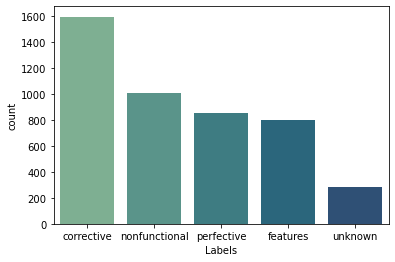

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Labels", data=df,order = df['Labels'].value_counts().index, palette="crest")
plt.savefig('../figures/labelled_dataset_distribution', dpi=300)

The problem could be addressed by taking F-measure as accuracy measure and by the correct application of the cross-validation process. 

<a id='preprocess'></a>
## Preprocessing text

The text in the commit messagges could be full of inconsistencies and ambiguities, so it's time to work a little bit on text preprocessing in order to get clean messages that retains all the useful informations contained in the original text but free of non-significant noise. 
It helps to create for features for the text messages later.

Process applied:
> - Lower-casing: coverting all the text in the lower-case. It is helpful in text featurization techniques like term frequency, TFIDF since it prevents duplication of same words having different casing.
> - Removing stopwords: removing trivial words like “I”, "if", "a", “the”, “you”, etc. that appear so frequently in the text that they may distort many NLP operations without adding much valuable information.
> - General cleaning: keeping only alphabets, digits and certain words (punctuations, qmarks, tabs etc. are removed)
> - Lemmatization: converting the word to its base form or lemma (ex: run, ran, runs --> run)

In [6]:
%run ../scripts/text_data_preprocessing.ipynb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
norm_corpus = preprocess(df['Messages'], cleaning = True, stemming = False, stem_type = None, 
                         lemmatization = True, remove_stopwords = True)
df['Clean Messages'] = norm_corpus
# view sample data
df.head(1050)


,Labels,Messages,Clean Messages
0,perfective,Add marble diagrams for Single operators.--\n,add marble diagram single operators
1,perfective,Change hasException to hasThrowable--\n,change hasexception hasthrowable
2,features,Trying to extend the Scheduler interface acco...,try extend scheduler interface accord comment 19
3,features,RunAsync method for outputting multiple value...,runasync method output multiple value
4,corrective,forEach with Action1 but not Observer--I re-r...,foreach action1 observer read msdn docs find p...
...,...,...,...
1045,corrective,CAMEL-1078. Fix potential NPE.--git-svn-id: ...,camel 1078 fix potential npe git svn id https ...
1046,perfective,CAMEL-1134 make the ZipDataFormat Stream frie...,camel 1134 make zipdataformat stream friendly ...
1047,perfective,tidied up some of the default JMS configurati...,tidy default jms configurations detail see htt...
1048,perfective,Polished code--git-svn-id: https://svn.apache...,polish code git svn id https svn apache org re...


<a id='split'></a>
## Splitting in Train and Test

- `Training dataset` to train and pre-evaluate the models (thought K-fold-cross-validation)
- `Test dataset` only to test and make a final evaluation of the model 

A 20% of the observations from the whole dataset was taken to build the `Test dataset`

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['Clean Messages'].tolist(), df['Labels'].tolist(), test_size=0.2, random_state=4)

In [9]:
len(x_train), len(x_test)

(3622, 906)

We obtain a total of 3622 samples for the training dataset and 906 samples for the test dataset

<a id='classic_models'></a>
# Classic models

<a id='feat_extr'></a>
## Feature Extraction by TF-IDF

Classifier and algorithms need to be fed with a numerical feature vector of fixed lenght for each document/message instead of the raw text. 

TF-IDF is used as feature extraction technique.
It combines two metrics:
+ TF (Term frequency): how many times a word appears in a document
+ IDF (Inverse Document frequency): how many times the word appears in other documnent.

For a certain word in a document the defined function goes up proportionally as the number of appearances in that document increase and goes down proportionally as the number of its appearances in the other documents increase.

The idea of this beahaviour of the measure is to give more importance to the terms that appear in the document, but in general are less frequent.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_transformer = TfidfVectorizer(ngram_range=(1,2),lowercase=True, max_features=5000) #getting the top 5000 features
x_vect_train = text_transformer.fit_transform(x_train) #fitting the text transformer on the training dataset and vectoring the training dataset
x_test_vect = text_transformer.transform(x_test) #vectorize the test dataset

In [11]:
x_vect_train

<3622x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 44938 stored elements in Compressed Sparse Row format>

Each of 3622 commit messages is now represented by 5000 features.

Every feature represent the tf-idf score for every unigrams and bigrams created (top 5000).

Saving the vectorizer:

In [12]:
import pickle

with open('../results/vectorizer.pkl', 'wb') as fid:
    pickle.dump(text_transformer, fid)

#### Now getting the most correleted terms per class (label)

Computing chi-squared stats between each non-negative feature and relative label/class. <br />
Aim: what are the most representative unigrams and bigrams for each label?

In [13]:
from sklearn.feature_selection import chi2
import numpy as np

labels=['corrective','features','perfective','nonfunctional','unknown']
top_unigrams=[]
top_bigrams=[]

for label in labels:    
    chi2_per_feature = chi2(x_vect_train, [y==label for y in y_train] ) #gives 2 arrays of n-features dimension, array0 chi2 (our interest) array1 p-value
    indices = np.argsort(chi2_per_feature[0])
    feature_names = np.array(text_transformer.get_feature_names())[indices] #getting corrisponding feature names indifferently unigrams and bigrams
    #split unigrams-bigrams
    unigrams = [feat for feat in feature_names if len(feat.split(' ')) == 1]
    bigrams = [feat for feat in feature_names if len(feat.split(' ')) == 2]
    top_unigrams.append(unigrams[-2:]) #top2
    top_bigrams.append(bigrams[-2:]) 
    
top_features_df=pd.DataFrame()
top_features_df['Labels']=labels
top_features_df['Unigrams']=top_unigrams
top_features_df['Bigrams']=top_bigrams
top_features_df


,Labels,Unigrams,Bigrams
0,corrective,"[bug, fix]","[improve performance, fix bug]"
1,features,"[add, feature]","[add feature, new feature]"
2,perfective,"[design, structure]","[structure refactoring, package structure]"
3,nonfunctional,"[improve, performance]","[performance improvements, improve performance]"
4,unknown,"[remove, duplicate]","[duplicate code, remove duplicate]"


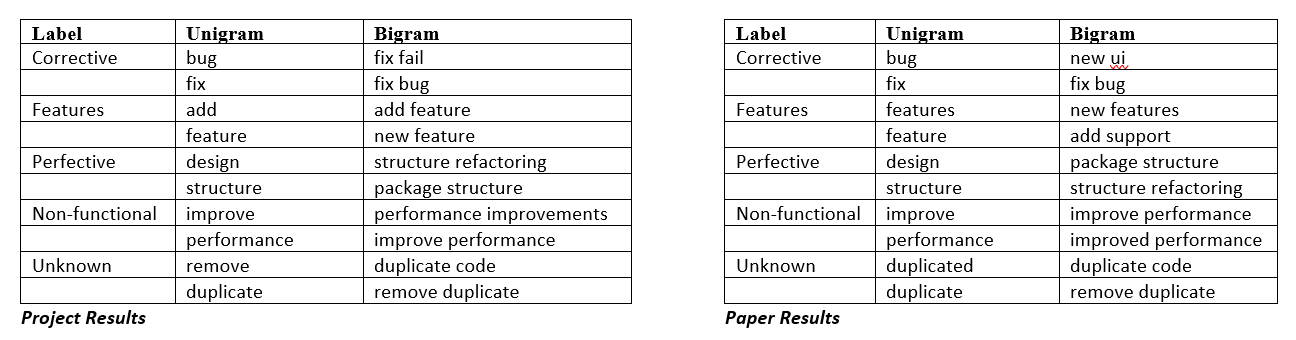

<a id='models'></a>
## Classification baseline models definition

Inizialization of five different models based on different supervised learning algorithms:

> - Logistic Regression: it uses the logistic (sigmoid) mathematical function to estimate the parameter values. These are the coefficients of all our features such that the overall loss is minimized when predicting the outcome/class. The maximum likelihood estimation (MLE) framework is at play in trying to fit the model to the data.
> - Random Forest Classifier: a meta estimator (it is an ensamble learning method) that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
> - Multinomial Naive Bayes classifier: it is a probabilistic learning method that mostly used in NLP. The algorithm is based on the Bayes theorem and predicts the tag of a text such as a piece of email or newspaper article. It calculates the probability of each tag for a given sample and then gives the tag with the highest probability as output. The naive assumption consists in considering each feature independent from the others. 
> - Linear Support Vector Classifier: it represents the training data samples as points in space such that points belonging to either class can be separated by a wide gap between them (hyperplane) and the new data points to be predicted are assigned classes based on which side of this hyperplane they fall into. 
> - Decision Tree Classifier: the algorithm uses training data to create rules that can be represented by a tree structure. Like any other tree representation, it has a root node, internal nodes, and leaf nodes. The internal node represents condition on attributes, the branches represent the results of the condition and the leaf node represents the class label.


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

LR = LogisticRegression() #plain vanilla, standard hyperparameters
RF = RandomForestClassifier()
NB = MultinomialNB()
SVC = LinearSVC()
CART = DecisionTreeClassifier()

models_df=pd.DataFrame()
models_df['Models reference']=['LR','RF','NB','SVC','CART']  ##rather than column put it as index
models_df['Model object']=[LR,RF,NB,SVC,CART]
models_df

,Models reference,Model object
0,LR,LogisticRegression()
1,RF,RandomForestClassifier()
2,NB,MultinomialNB()
3,SVC,LinearSVC()
4,CART,DecisionTreeClassifier()


<a id='cv_val'></a>
## CV score "pre-evaluation"

Testing the predictive ability of each model through 5-fold cross-validation (data is splitted in 5, 4 taken as training and the other as test each of the 5 iterations) with 5 repetitions.

The metric used to evaluate the performance is the `F-measure` (F1-score). It takes into account both precision and recall, by computing their harmonic mean, which is given by the formula: `F1-score = 2 × (precision × recall)/(precision + recall)`.
The `f1_macro` is computed for each class then it's macro-averaged equally weighting each class, this is done to counteract the possible imbalance of the classes (another way possible way? oversampling/undersampling the classes).

Note that if the hypothesis taken into account is that the distribution of the labels in the labelled dataset is representative of the "real commits world" we could use `f1_weighted`, which computed the f-measure average weighted by support (the number of true instances for each label)

,Models reference,Model object,F-measures
0,LR,LogisticRegression(),0.893572
1,RF,RandomForestClassifier(),0.900004
2,NB,MultinomialNB(),0.808694
3,SVC,LinearSVC(),0.905700
4,CART,DecisionTreeClassifier(),0.892561


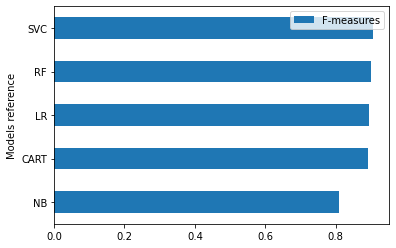

In [15]:
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold, StratifiedKFold
import numpy as np

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=77)

scores=[]

for model in models_df['Model object'].tolist() :
    cv_results = cross_val_score(model, x_vect_train, y_train, cv=rkf, scoring='f1_macro')
    scores.append(np.mean(cv_results))

models_df['F-measures']=scores

models_df.sort_values(by=['F-measures']).plot.barh(y='F-measures', x='Models reference'); 
plt.savefig('../figures/classic_random_models_performance', dpi=300); models_df 


<a id='logit_tuning'></a>
## Logit tuning

Searching in the hyperparameters space of the Logit model the best value for the hyperparameter C. A set of possible parameters is defined in `grid['C']`. Amongst the proposed values, the one that allows to achieve the best F-measure is reported.

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
grid = dict()
grid['C'] = [0.5,1,3,4,5,7,8,10]
tune_LR=LogisticRegression(max_iter=1000) #max_iter set to 1000 to avoid convergence error
gs_tune_LR=GridSearchCV(tune_LR,grid,cv=rkf,scoring="f1_macro")
gs_tune_LR.fit(x_vect_train,y_train)

print("Best hyperparamters", gs_tune_LR.best_params_)
print("F-measure :",gs_tune_LR.best_score_)

Best hyperparamters {'C': 10}
F-measure : 0.9050403860190513


<a id='logit_final_ev'></a>
## Logit final evaluation

Creating the model object with the hyperparameters found and fitting it to the training dataset:

In [18]:
LR_final=LogisticRegression(C=10, max_iter=1000)
LR_final.fit(x_vect_train, y_train);

Predicting the values of the test set

In [19]:
y_test_pred=LR_final.predict(x_test_vect)

Final evaluation of the performance through the F-measure on the test set, kept apart the training process until now

In [20]:
from sklearn.metrics import f1_score

print("F-measure:",f1_score(y_test_pred,y_test, average="macro"))

F-measure: 0.9135718396987802


#### Plotting the confusion matrix:
Really useful to have a look at the predicted labels against the actual labels. It is possible to see for a certain label the number of correct guesses and how (quantitevely) it's confused for which other label.

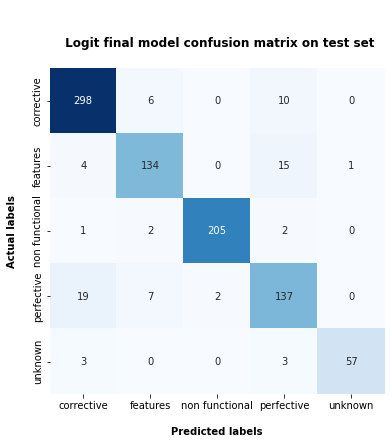

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt="d") #Annotate each cell with the numeric value using integer formatting
ax.set_title('\n\n Logit final model confusion matrix on test set\n', fontweight='bold');
ax.set_xlabel('\nPredicted labels',fontweight='bold')
ax.set_ylabel('Actual labels\n',fontweight='bold');
ax.xaxis.set_ticklabels(['corrective', 'features', 'non functional', 'perfective', 'unknown']);
ax.yaxis.set_ticklabels(['corrective', 'features', 'non functional', 'perfective', 'unknown']);
plt.savefig('../figures/logit_confusion_matrix')


It is possible to observe that the class unknown that got the fewer example in the training dataset is very well predicted in the test dataset with an accuracy of 57/58. (The concern was that maybe it could be treated as a outlier in the learning process with the outcome of poor prediction in the test dataset) 

Saving the training model:

In [22]:
import pickle

with open('../results/Classic_LR_final_model.pkl', 'wb') as fid:
    pickle.dump(LR_final, fid)

<a id='fasttext'></a>
# Fasttext model 

FastText is an open-source, free library from Facebook AI Research (FAIR) for learning word embeddings and word classifications. It proposes a state-of-the-art NLP algorithm, it relies on the skip-gram model, where each word is represented as a bag of character n-grams. Then, the vector representation is associated with each character n-gram, and these words are basically the sum of these representations. It allows the model to compute representations for words that did not appear in
the training data. At the core featurized text is still feeded to a classic linear classifier, the multinomial logistic regression.

Keeping the same dataset split and pre-cleaning as the one utilized in classic models

Re-adding "\_\_\_label\___" before every label as fasttext demands:

In [23]:
_y_train=[]
for y in y_train:
    _y_train.append("__label__"+y)

_y_test=[]
for y in y_test:
    _y_test.append("__label__"+y)
_y_train

_y_train[:7] 

['__label__perfective',
 '__label__nonfunctional',
 '__label__features',
 '__label__perfective',
 '__label__features',
 '__label__corrective',
 '__label__nonfunctional']

Creating dataframe with training data and saving it as txt

In [24]:
_df=pd.DataFrame()
_df['y_train']=_y_train
_df['x_train']=x_train
np.savetxt('../results/commits_train_fasttext.txt', _df.values, fmt='%s')

_df_test=pd.DataFrame()
_df_test['_y_test']=_y_test
_df_test['x_test']=x_test
np.savetxt('../results/commits_test_fasttext.txt', _df_test.values, fmt='%s')

The fasttext python module builds only on Mac OS and Linux. Have a look at [this](https://medium.com/@oleg.tarasov/building-fasttext-python-wrapper-from-source-under-windows-68e693a68cbb) to make it work under windows 

In [25]:
import fasttext 

Training the fasttext model feeding the training data.
<br />
Using the `autotuneValidationFile` option to automcatically optimize the hyperparameters based on the f1-score performance on the test dataset

In [26]:
fasttext_model = fasttext.train_supervised('../results/commits_train_fasttext.txt', autotuneValidationFile='../results/commits_test_fasttext.txt', verbose=3)

Getting all the predictions in a list

In [27]:
y_pred_raw=[]
for i in x_test:
    y_pred_raw.append(fasttext_model.predict(i))
y_pred_raw[:5]

[(('__label__features',), array([1.00001001])),
 (('__label__nonfunctional',), array([1.00000477])),
 (('__label__perfective',), array([0.98517072])),
 (('__label__nonfunctional',), array([1.00001001])),
 (('__label__corrective',), array([1.00001001]))]

Getting a clean list

In [28]:
y_pred_clean=[]
for i in y_pred_raw:
    y_pred_clean.append(i[0][0])
y_pred_clean[:5]


['__label__features',
 '__label__nonfunctional',
 '__label__perfective',
 '__label__nonfunctional',
 '__label__corrective']

In [29]:
from sklearn.metrics import f1_score
print("Fasttext model F-measure performance on the test dataset:",f1_score(_y_test , y_pred_clean, average="macro"))

Fasttext model F-measure performance on the test dataset: 0.9248571765657921


Saving the trained model:

In [30]:
fasttext_model.save_model("../results/fasttext_trained.bin")

<a id='observations'></a>
# Observations

- **Scarce standard text preprocessing**: the cleaning of the text messagges was poor. For example, no lemmatization was carried out. This could be threating at least for the efficiency of the process.
- **Special further text preprocessing** both on the labelled dataset and on non-labelled datasets before relative training and prediction to address frequent typos and mispelling by programmers with classic models (trying to reconstruct words). This is taken into account with fasttext model
- **Bigram consideration with TFIDF vectorization**: the bigrams are taken into account, but in a classfication task like commit classification, the real order of the words in the commit messages doesn't really contain valuable information. This can be proved by the fact that considering only unigrams does not change the results.
- **Multilabel classification** sometimes a commit can't be properly considered undear a single-simple label because it does equally different things to the code. So it may be useful working on a model which assign more labels (2) (or a %) to each commit if there's not a strong decision on its class (probability of the commit belonging to a specific label is not strong). 
- **Paper classic random models performances** Are 15/20 % worse in the paper than in the project, results similar to the paper could be obtained by drastically reducing the max features considered in vectorizing/featurizing the messages with TFIDF to 50/60, but this seems no-sense. 